<a href="https://colab.research.google.com/github/zidcenek/google_colab_projects/blob/master/tutorials_B201_cviceni_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TOY DATA GAN

In [2]:
import tensorflow as tf

from numpy.random import rand
from numpy.random import randn

import numpy as np
from keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from matplotlib import pyplot as plt

In [3]:
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [4]:
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

In [5]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

In [6]:
def generate_real_samples(n):
	X1 = rand(n) - 0.5
	X2 = X1**3
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = np.hstack((X1, X2))
	y = np.ones((n, 1))
	return X, y

In [7]:
def generate_latent_points(latent_dim, n):
	x_input = randn(latent_dim * n)
	x_input = x_input.reshape(n, latent_dim)
	return x_input

In [8]:
def generate_fake_samples(generator, latent_dim, n):
	x_input = generate_latent_points(latent_dim, n)
	X = generator.predict(x_input)
	y = np.zeros((n, 1))
	return X, y

In [9]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	x_real, y_real = generate_real_samples(n)
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	print(epoch, acc_real, acc_fake)
	plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
	plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	plt.show()

In [10]:
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		x_real, y_real = generate_real_samples(half_batch)
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		x_gan = generate_latent_points(latent_dim, n_batch)
		y_gan = np.ones((n_batch, 1))
		gan_model.train_on_batch(x_gan, y_gan)
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

1999 0.4300000071525574 0.3100000023841858


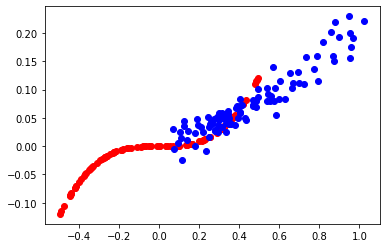

3999 0.4000000059604645 1.0


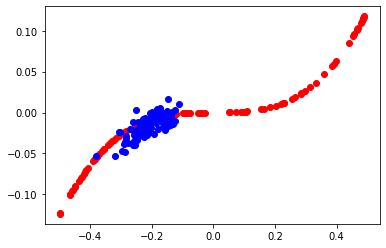

5999 0.5699999928474426 0.9599999785423279


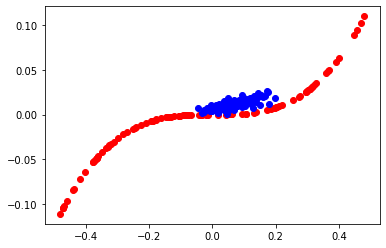

7999 0.36000001430511475 0.5


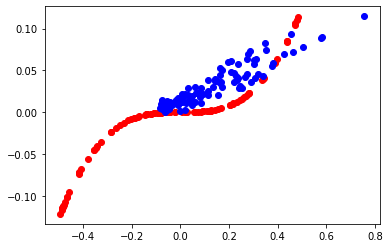

9999 0.47999998927116394 0.4399999976158142


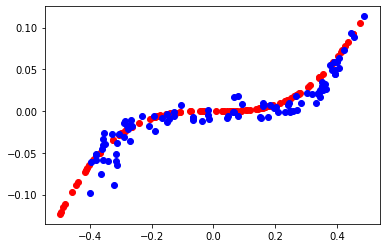

In [11]:
latent_dim = 5
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
train(generator, discriminator, gan_model, latent_dim)

# MNIST GAN

In [14]:
from keras.datasets.fashion_mnist import load_data
(trainX, trainy), (testX, testy) = load_data()
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4423680/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


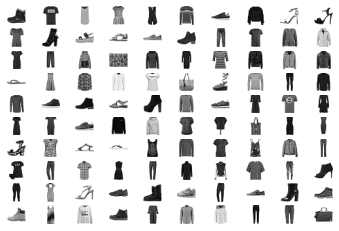

In [15]:
for i in range(100):
	plt.subplot(10, 10, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [ ]:
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def define_generator(latent_dim):
	model = Sequential()
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
	return model

In [ ]:
def define_gan(generator, discriminator):
	discriminator.trainable = False
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def load_real_samples():
	(trainX, _), (_, _) = load_data()
	X = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2], 1))
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	return X

In [ ]:
def generate_real_samples(dataset, n_samples):
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	x_input = generate_latent_points(latent_dim, n_samples)
	X = generator.predict(x_input)
	y = np.zeros((n_samples, 1))
	return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			X_real, y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			X_gan = generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
    print('Epoch: ', i)
	g_model.save('generator.h5')

In [ ]:
latent_dim = 100
discriminator = define_discriminator()
generator = define_generator(latent_dim)
gan_model = define_gan(generator, discriminator)
dataset = load_real_samples()
train(generator, discriminator, gan_model, dataset, latent_dim)

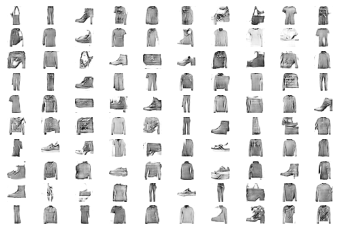

In [ ]:
from keras.models import load_model

def generate_latent_points(latent_dim, n_samples):
	x_input = np.random.randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
 
model = load_model('generator.h5')
latent_points = generate_latent_points(100, 100)
X = model.predict(latent_points)
show_plot(X, 10)

# CONDITIONAL GAN

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	
  in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	
  in_image = Input(shape=in_shape)
	merge = Concatenate()([in_image, li])
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.25)(fe)
 
	out_layer = Dense(1, activation='sigmoid')(fe)

	model = Model([in_image, in_label], out_layer)

	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [ ]:
def define_generator(latent_dim, n_classes=10):

	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	li = Reshape((7, 7, 1))(li)

	in_lat = Input(shape=(latent_dim,))
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	merge = Concatenate()([gen, li])
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
 
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

	model = Model([in_lat, in_label], out_layer)
 
	return model

In [ ]:
def define_gan(g_model, d_model):

	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def load_real_samples():
	(trainX, trainy), (_, _) = load_data()
	X = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2], 1))
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	return [X, trainy]

In [ ]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = np.random.randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = np.random.randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=25, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			y_gan = ones((n_batch, 1))
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
    print('Epoch: ', i)
	g_model.save('cgan_generator.h5')

In [ ]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)
gan_model = define_gan(g_model, d_model)
dataset = load_real_samples()
train(g_model, d_model, gan_model, dataset, latent_dim)

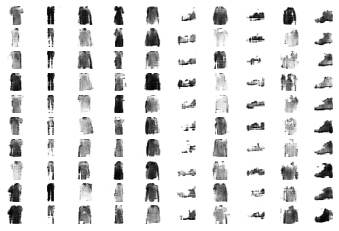

In [ ]:
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = np.random.randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 
def save_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()
 
model = load_model('cgan_generator.h5')
latent_points, labels = generate_latent_points(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X  = model.predict([latent_points, labels])
X = (X + 1) / 2.0
save_plot(X, 10)